In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import veloxchem as vlx

au2ang = 0.529177

atom_xyz = """1
He atom
He    0.000000000000        0.000000000000        0.000000000000
"""

dimer_xyz = """2
He dimer
He    0.000000000000        0.000000000000        0.000000000000
He    0.000000000000        0.000000000000        dimer_separation
"""

In [2]:
atom = vlx.Molecule.read_xyz_string(atom_xyz)
atom_basis = vlx.MolecularBasis.read(atom, "aug-cc-pvtz", ostream=None)

dimer = vlx.Molecule.read_xyz_string(dimer_xyz.replace("dimer_separation", "5.0"))
dimer_basis = vlx.MolecularBasis.read(dimer, "aug-cc-pvtz", ostream=None)

In [3]:
scf_drv = vlx.ScfRestrictedDriver()
mp2_drv = vlx.mp2driver.Mp2Driver()
scf_drv.ostream.mute()
mp2_drv.ostream.mute()

scf_results = scf_drv.compute(atom, atom_basis)
hf_atom_energy = scf_drv.get_scf_energy()

mp2_results = mp2_drv.compute(atom, atom_basis, scf_drv.mol_orbs)
mp2_atom_energy = hf_atom_energy + mp2_results["mp2_energy"]

In [4]:
distances = np.linspace(2.75, 5.0, 10)
hf_dimer_energies = []
mp2_dimer_energies = []

for dist in distances:

    dimer = vlx.Molecule.read_xyz_string(
        dimer_xyz.replace("dimer_separation", str(dist))
    )

    scf_results = scf_drv.compute(dimer, dimer_basis)
    hf_dimer_energies.append(scf_drv.get_scf_energy())
    mp2_results = mp2_drv.compute(dimer, dimer_basis, scf_drv.mol_orbs)
    mp2_dimer_energies.append(scf_drv.get_scf_energy() + mp2_results["mp2_energy"])

hf_dimer_energies = np.array(hf_dimer_energies)
mp2_dimer_energies = np.array(mp2_dimer_energies)

In [5]:
hf_interaction_energies = hf_dimer_energies - 2 * hf_atom_energy
mp2_interaction_energies = mp2_dimer_energies - 2 * mp2_atom_energy

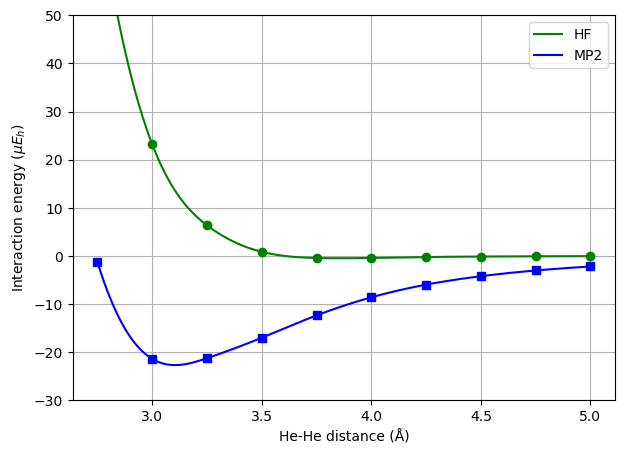

In [6]:
R = np.linspace(2.75, 5.0, 1000)

plt.figure(figsize=(7, 5))
x, y = distances, hf_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "g-", label="HF")
plt.plot(x, y, "go")

x, y = distances, mp2_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "b-", label="MP2")
plt.plot(x, y, "bs")

plt.xlabel("He-He distance (Å)")
plt.ylabel(r"Interaction energy ($\mu E_h$)")
plt.ylim(-30, 50)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
c6_drv = vlx.C6Driver()
c6_drv.ostream.mute()
scf_results = scf_drv.compute(atom, atom_basis)
c6_results = c6_drv.compute(atom, atom_basis, scf_results)

hf_c6 = c6_results["c6"]

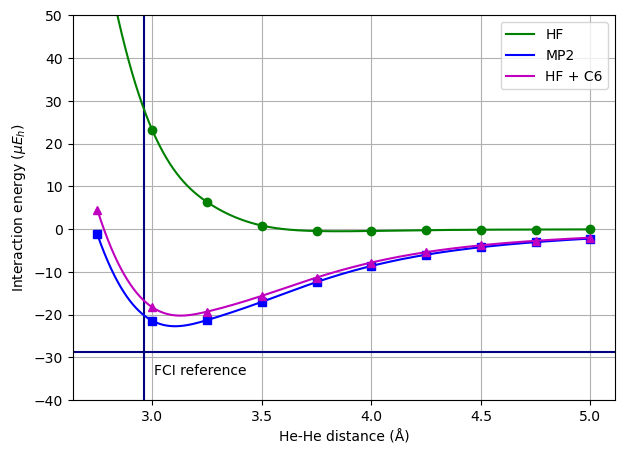

In [8]:
plt.figure(figsize=(7, 5))

# Reference data at FCI level
plt.axvline(5.6 * au2ang, color="navy")
plt.axhline(-28.76, color="navy")
plt.text(3.01, -34, "FCI reference")

x, y = distances, hf_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "g-", label="HF")
plt.plot(x, y, "go")

x, y = distances, mp2_interaction_energies * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "b-", label="MP2")
plt.plot(x, y, "bs")

x, y = distances, (hf_interaction_energies - hf_c6 / (distances / au2ang) ** 6) * 1e6
f = scipy.interpolate.interp1d(x, y, kind="cubic")
plt.plot(R, f(R), "m-", label="HF + C6")
plt.plot(x, y, "m^")

plt.xlabel("He-He distance (Å)")
plt.ylabel(r"Interaction energy ($\mu E_h$)")
plt.ylim(-40, 50)
plt.legend()
plt.grid(True)
plt.show()